In [19]:
#### data augmentation, according to the distribution, repeat and oscilate 
import numpy as np
import matplotlib.pyplot as plt
import os, sys, time
import datetime
import fnmatch
import math
import pandas as pd
from glob import glob
import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [20]:
#### if train
train = pd.read_csv('MODIS_result_TrainingSet_2b.csv')

In [3]:
#### if validation
valid = pd.read_csv('MODIS_result_ValidationSet_2b.csv')
train = valid.copy()

In [21]:
train['year_train'] = int(2015)
mask = train.yday >= 2016000
train['year_train'][mask] = 2016
train['doy'] = train.yday.values - train.year_train*1000 
train['doy'] = train['doy'] - 1 

In [23]:
train['date'] = train['year_train'].copy()
train['date'][mask] = pd.to_datetime(train.doy,origin=str(2016),unit='D')
train['date'][~mask] = pd.to_datetime(train.doy,origin=str(2015),unit='D')
train = train.drop(columns = ['yday', 'doy'])

In [2]:
havard = train[(train.lat<43) & (train.lat>41) & (train.lon<-71) & (train.lon>-73)]
hv = havard.groupby('date').mean()

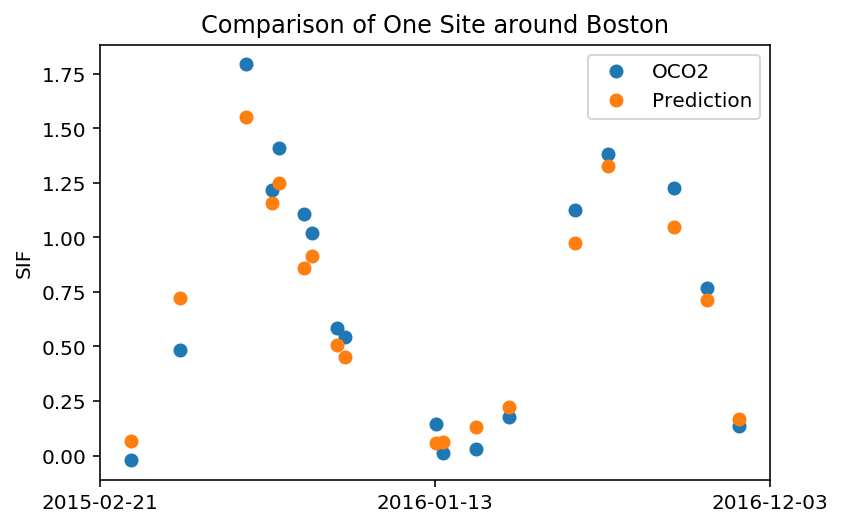

In [32]:
fig, ax = plt.subplots()
ax.plot(hv.index, hv.SIF_obs, marker='o', linestyle='None', label='OCO2')
ax.plot(hv.index, hv.SIF_pre, marker='o', linestyle='None', label='Prediction')
start, end = ax.get_xlim()
ax.xaxis.set_ticks([start, (start+end)/2, end])
plt.title('Comparison of One Site around Boston')
plt.ylabel('SIF')
#ax.xaxis.set_ticks(np.arange(start, end, 0.712123))
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.legend()
plt.show()

#plt.rcParams['savefig.dpi'] = 220
fig.savefig('Havard.png')

In [1]:
havard = train[(train.lat<-10) & (train.lat>-12) & (train.lon<-70) & (train.lon>-72)]
hv = havard.groupby('date').mean()

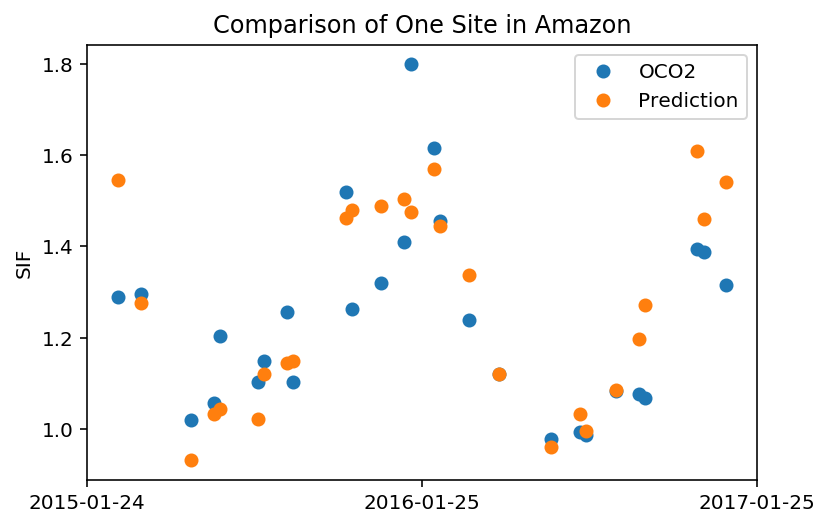

In [36]:
fig, ax = plt.subplots()
ax.plot(hv.index, hv.SIF_obs, marker='o', linestyle='None', label='OCO2')
ax.plot(hv.index, hv.SIF_pre, marker='o', linestyle='None', label='Prediction')
start, end = ax.get_xlim()
ax.xaxis.set_ticks([start, (start+end)/2, end])
#ax.xaxis.set_ticks(np.arange(start, end, 0.712123))
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.title('Comparison of One Site in Amazon')
plt.ylabel('SIF')
#ax.xaxis.set_ticks(np.arange(start, end, 0.712123))
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.legend()
plt.show()

#plt.rcParams['savefig.dpi'] = 220
fig.savefig('Amazon.png')

In [9]:
sif_obs_mean = train.groupby(['lat','lon']).mean().SIF_obs.unstack()

In [10]:
sif_pre_mean = train.groupby(['lat','lon']).mean().SIF_pre.unstack()

In [14]:
lat_max = int(np.max(sif_obs_mean.index))
lat_min = int(np.min(sif_obs_mean.index))
lat_num = int((lat_max-lat_min)/1)

lon_max = int(np.max(sif_obs_mean.columns))
lon_min = int(np.min(sif_obs_mean.columns))
lon_num = int((lon_max-lon_min)/1)

# time_num = len(np.unique(train.date))

# [lat_num, lon_num]
latt = np.linspace(lat_min,lat_max,lat_num+1)
lonn = np.linspace(lon_min,lon_max,lon_num+1)

In [13]:
import xarray as xr
train_nc = xr.Dataset(data_vars={'SIF_obs': (('lat', 'lon'), sif_obs_mean),
                                 'SIF_pre': (('lat', 'lon'), sif_pre_mean)},
                      coords={'lat': sif_obs_mean.index,
                              'lon': sif_obs_mean.columns})
train_nc

<xarray.Dataset>
Dimensions:  (lat: 2591, lon: 5752)
Coordinates:
  * lat      (lat) float64 -54.48 -54.38 -54.33 -54.12 ... 75.92 76.03 76.12
  * lon      (lon) float64 -171.6 -165.0 -164.9 -164.1 ... 178.4 178.5 178.5
Data variables:
    SIF_obs  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    SIF_pre  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

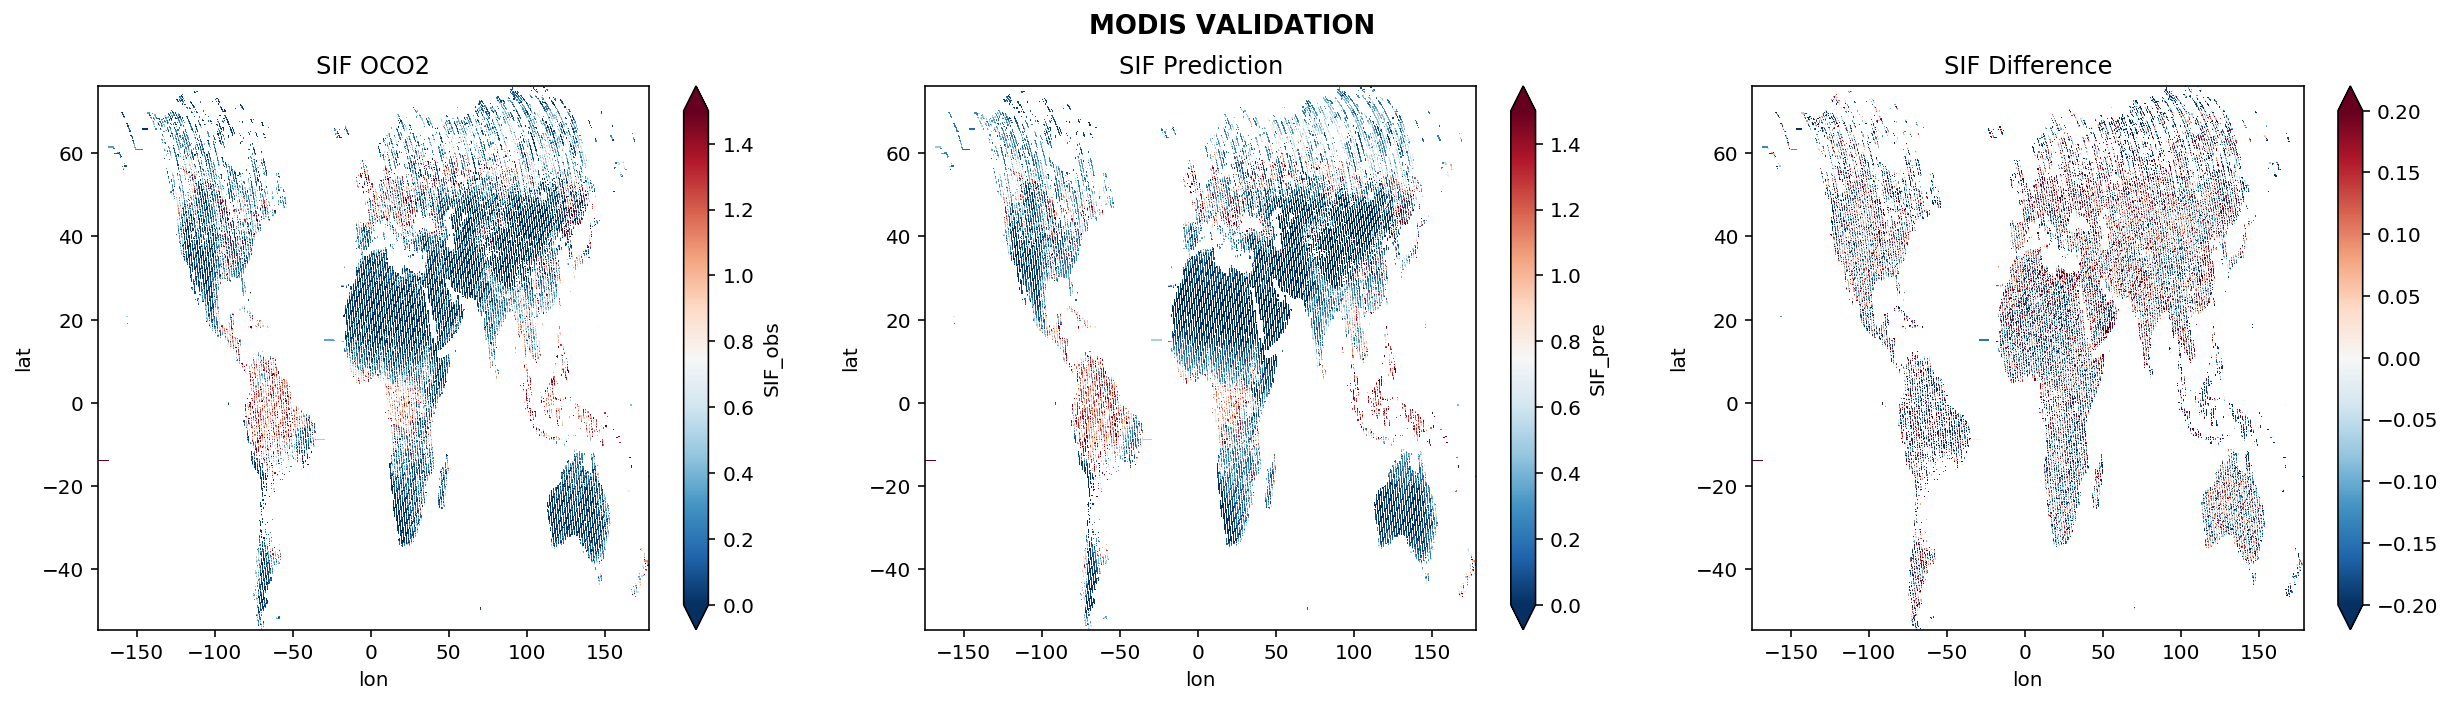

In [18]:
fig, ax = plt.subplots(ncols=3, figsize = (21,5))
train_nc.SIF_obs.plot(ax=ax[0], vmin=0, vmax = 1.5, cmap = 'RdBu_r')
train_nc.SIF_pre.plot(ax=ax[1], vmin=0, vmax = 1.5, cmap = 'RdBu_r')
(train_nc.SIF_obs-train_nc.SIF_pre).plot(ax=ax[2], vmin=-0.2, vmax = 0.2, cmap = 'RdBu_r')

ax[0].set_title('SIF OCO2')
ax[1].set_title('SIF Prediction')
ax[2].set_title('SIF Difference')
fig.suptitle('MODIS VALIDATION', fontsize=13, fontweight='bold')

plt.rcParams['savefig.dpi'] = 220
plt.savefig('Validationset_SIF_MODIS.png')

In [53]:
train_nc_new = train_nc.reindex(lat=latt,lon=lonn, method='nearest')

In [56]:
train_nc_new

<xarray.Dataset>
Dimensions:  (lat: 137, lon: 359)
Coordinates:
  * lat      (lat) float64 -55.0 -54.0 -53.0 -52.0 -51.0 ... 78.0 79.0 80.0 81.0
  * lon      (lon) float64 -179.0 -178.0 -177.0 -176.0 ... 177.0 178.0 179.0
Data variables:
    SIF_obs  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    SIF_pre  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

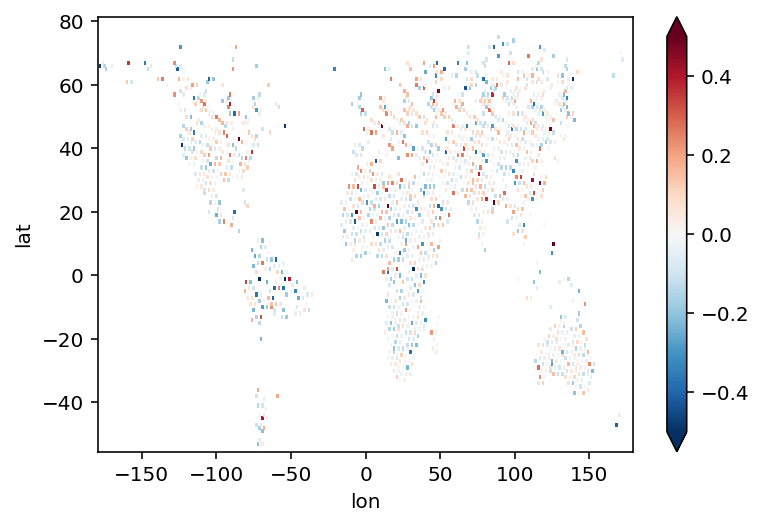

In [54]:
(train_nc_new.SIF_obs-train_nc_new.SIF_pre).plot(vmin=-0.5, vmax = 0.5, cmap = 'RdBu_r')

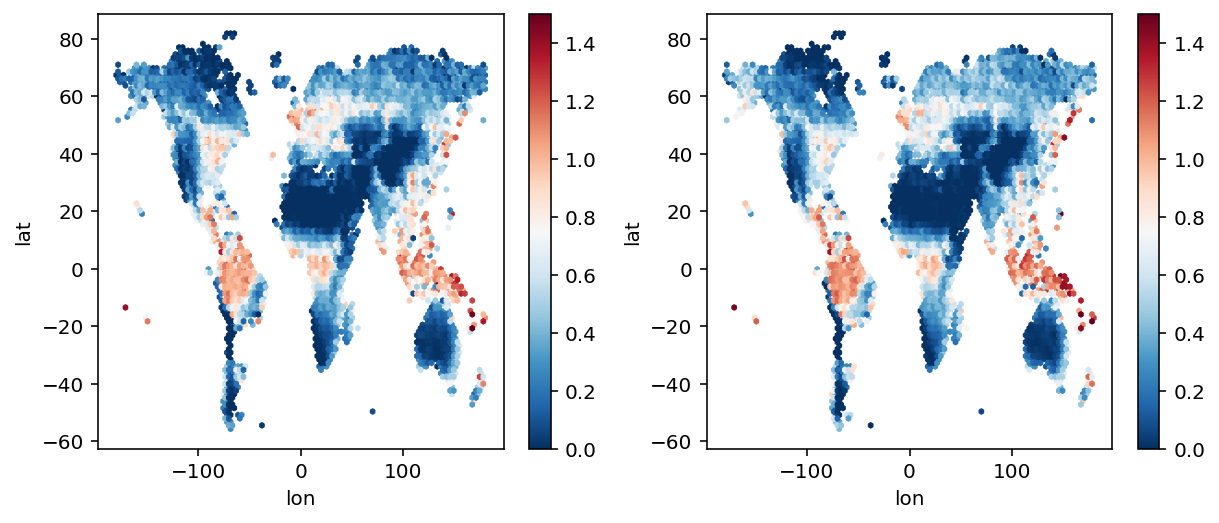

In [29]:
fig, ax = plt.subplots(ncols=2, figsize = (10,4))
train.plot.hexbin('lon', 'lat', C='SIF_obs', ax = ax[0], cmap = 'RdBu_r', vmin = 0, vmax = 1.5)
train.plot.hexbin('lon', 'lat', C='SIF_pre', ax = ax[1], cmap = 'RdBu_r', vmin = 0, vmax = 1.5)